# MsThesis draft

## Progress on the 3rd year students' plan

### weeks 1-2 (18.02.21)

Started from the end of the second week. Although, all the tools were ready.

**What**: generative bayesian model  
**Why**: 
 - to have more data (datasets are small)
 - to augment data for better classification quality
 - to understand where data come from
 - to check every epoch with acquires distribution and use it as an additional info(?)

### week 3 (25.02.21)

1. Abstract
2. Introduction
3. Literature

See https://www.overleaf.com/read/xvdctzhxtryw

Read papers on LMUs. The data we're working with doesn't sound like a good one to do this stuff.

So, I guess, we'll do Bayesian models for data generation. It will be used in an augmentation context.

Practical problem (goal): to reduce number of stimulus activations for the resulting models, so that communication via BCI would be faster and less frusrtating. 

**Begin-talk**


**The project goal**  
The motivation rises from the desire to better the user experiences with the P300 BCI devices. Which can be achieved by lowering the time needed to choose a stimulus and by increasing the accuracy of that action. One of the ways to do this -- to obtain more and better data.  
**The main idea**  
Bayesian models allow to investigate different hypothesis about data distribution. And use this knowledge both for augmentation and for gaining the additional info on inference step, like how well the sample fits the aforenamed distribution.  
**The expected result**  
Empirically proved data generation hypothesis and a model based on it, which allows to achieve the project goal. 

### week 4 (04.03.21)

    State your problem, write a description of your basic algorithm, prepare your computational experiment

Problem statement: in overleaf. Needs to be checked.

As a basic algorithm, I can remember we implemented vaes as a part of bayesian models course. So I'm gonna try that.

Code can be found in the second part of the doc

### week 5 (11.03.21)

    Basic code, draft report on the basic algorithm.

I have basic code for data processing, and configs templates for computational experiments with different models. I am in a process of understanding what source code from our package can be used in public repositories.

### week 6 (18.03.21)

    Code, visual presentation of results

### week 7 (25.03.21)

    Describe the algorithm

I'm a little behind on this due to personal reasons. 

Сложный уровень: выставить гипотезы и условия. Сформулировать и доказать теорему.

### upcoming

#### week 8 (01.04.21)

    Make the error and quality analysis. Finalise the computational experiment. 

#### week 9 (08.04.21)

    Prepare the theoretical part and computational experiment. Explain the figures, write conclusions. Ready to the second checkpoint. 

#### weeks 10-12 

    finalisation

## Code part

### Imports 

In [1]:
#import patch_path
from code_p300.datasets import P300Dataset, ListDataset
from code_p300.utils import data_dir
from code_p300 import visualizers as vis
import torch

### Data 

In [17]:
# dataset collected at our lab
# it's the lightest one I know, so I'll use it
# in the upcoming weeks it will be public and available through moabb package
# also I will test everythong on public datasets like EPFL and BrainInvaders (through our interfaces)
# there's an option to work with moabb datasets directly. 
# But in my opinion, our version is more flexible ad familiar

In [2]:
# Some records have different number of acts. 
# It doesn't affect anything, but raises warnings while creating dataset
# Will be fixed soon
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

In [3]:
ds_train = P300Dataset(data_dir / 'huge_demons', split = 'train')
ds_train

P300Dataset: huge_demons
48 records of 17 to 19 acts
epochs shaped (50, 8, 30)

In [4]:
ds_val = P300Dataset(data_dir / 'huge_demons', split = 'val')
ds_val

P300Dataset: huge_demons
12 records of 18 to 19 acts
epochs shaped (50, 8, 30)

In [5]:
binds_train = ds_train.binary_dataset()
binds_val = ds_val.binary_dataset()
binds_train, binds_val

(Binary P300 dataset of 48 records
 eeg shape: torch.Size([945, 8, 30]),
 Binary P300 dataset of 12 records
 eeg shape: torch.Size([950, 8, 30]))

In [6]:
def binary_transform(bin_ds):
        '''Transforms data of binary dataset to friendly format, leaving only target epochs

        Args:
            bin_ds: BinaryDataset instance

        Returns:
            list of (epoch, label) tuple
        '''

        items = []
        for epochs_i, labels_i in bin_ds:
            for epoch, label in zip(epochs_i, labels_i):
                #if label==1:
                items.append((torch.flatten(epoch),label))
        return items


In [7]:
data = binary_transform(binds_train)
train_set = ListDataset(data)

In [8]:
data = binary_transform(binds_val)
valid_set = ListDataset(data)

### Simple use of AE as encoding (just to remember what it's like)

In [12]:
from code_p300.bayesian import  vae

In [13]:
from torch.utils.data import  DataLoader
from tqdm import tqdm
from torch import optim

def train_on_batch(model,
                   batch_of_x,
                   batch_of_y,
                   optimizer):

    model.zero_grad()
    loss = model.loss(batch_of_x, batch_of_y)
    loss.backward()
    optimizer.step()
    return


def train_epoch(model,
                train_generator,
                optimizer):

    model.train()
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        train_on_batch(model, batch_of_x, batch_of_y, optimizer)
    return


def trainer(model,
            optimizer,
            dataset,
            count_of_epoch=5,
            batch_size=64,
            progress=None):

    iterations = range(count_of_epoch)
    
    if progress is not None:
        iterations = progress(iterations)

    for it in iterations:
        batch_generator = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True)
        train_epoch(
            model=model,
            train_generator=batch_generator,
            optimizer=optimizer)
    return

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
from code_p300.models import clfs_full, bin_scores

In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

def encode_epochs(model, bin_ds):
    '''Gets BinaryDataset and transforms it to encoder latent space images of epochs and labels

    Encodes epochs with `encoder` part of passed model

    Args:
        model: model with encoder part to get latent representation of epochs
        bin_ds: BinaryDataset to transform

    Returns:
        tuple of arrays of epochs and labels
    '''
    epochs = []
    labels = []
    for epochs_i, labels_i in bin_ds:
        distr = model.q_z(epochs_i.view(-1, 240))
        encoded = model.sample_z(distr)
        encoded = encoded.detach()
        epochs.append(torch.flatten(encoded, 1))
        labels.append(labels_i)
        
    return torch.cat(epochs).numpy(), np.array(labels)


def evaluate_ae(model, bin_train, bin_val):
    '''Calculates binary metrics on validation dataset

    Transforms dataset with encode_epochs and uses LogisticRegression for predictions

    Args:
        model: already trained autoencoder to use
        dataset_train: dataset to train LogisticRegression on
        dataset_val: dataset for evaluation

    Returns:
        dict of scores values: accuracy, f1_score and roc-auc
    '''

    encoded_train, labels_train = encode_epochs(model, bin_train)
    encoded_val, labels_val = encode_epochs(model, bin_val)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(encoded_train, labels_train)
    labels_pred = lr.predict(encoded_val)

    acc = accuracy_score(labels_val, labels_pred)
    f1 = f1_score(labels_val, labels_pred)
    roc_auc = roc_auc_score(labels_val, labels_pred)
    return {'accuracy': acc, 'f1_score': f1, 'roc-auc': roc_auc}


In [6]:
from collections import defaultdict

from sklearn.base import clone

from code_p300.types import Directory
from code_p300.utils import score, tmp_dir


def evaluate_game(
    dataset: P300Dataset,
    train_acts: int,
    classifier,
    scores: tuple,
    *,
    augment_vae= None,
    vae = None,
    artifacts_dir: Directory = tmp_dir,
    verbose: bool = False,
    log: bool = True,
):
    '''Tests given dataset for metrics with default trainable classifier

    Args:
        dataset: obvious
        train_acts: number of first acts for each person to train on
        classifier: classifier object with standard sklearn interface

    Returns
        Dict with means and stds for each calculated metric
    '''
    # *** appears to be partly private code and depending on private constructs***
    # affects only multiclass labels, so must be ok not to use it

In [18]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [19]:
def plot_orig_reconstr(original_x, reconstructed_x):
    plt.figure(figsize = (14, 8))
    ticks = np.linspace(0, 30, 9)
    labels = np.linspace(ds_train.epoch_start*1000, ds_train.epoch_end*1000, 9, dtype=int)
    plt.plot(original_x.mean(axis=0), color = 'b', label = 'original eeg')
    plt.plot(reconstructed_x.mean(axis=0), color='g', label = 'reconstructed eeg')
    plt.xticks(ticks = ticks, labels = labels)
    plt.xlabel('miliseconds')
    plt.ylabel('normalized mkv')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

In [20]:
def binary_transform_target(bin_ds):
        '''Transforms data of binary dataset to friendly format, leaving only target or non-target epochs

        Args:
            bin_ds: BinaryDataset instance

        Returns:
            list of (epoch, label) tuple
        '''

        items = []
        for epochs_i, labels_i in bin_ds:
            for epoch, label in zip(epochs_i, labels_i):
                if (label.numpy()==1):
                    items.append((torch.flatten(epoch),label))
        return items


In [21]:
def plot_orig_sampled(original_x, reconstructed_x):
    plt.figure(figsize = (14, 8))
    ticks = np.linspace(0, 30, 9)
    labels = np.linspace(ds_train.epoch_start*1000, ds_train.epoch_end*1000, 9, dtype=int)
    plt.plot(original_x.mean(axis=0), color = 'b', label = 'original eeg')
    plt.plot(reconstructed_x.mean(axis=0), color='g', label = 'sampled eeg')
    plt.xticks(ticks = ticks, labels = labels)
    plt.xlabel('miliseconds')
    plt.ylabel('normalized mkv')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

In [22]:
epoch_shape= binds_train[0][0].shape[1:]
epoch_shape

torch.Size([8, 30])

#### train model 

In [12]:
model = vae.VAE(32, epoch_shape[0]*epoch_shape[1], device='cpu')

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
trainer(model=model,
        optimizer=optimizer,
        dataset=train_set,
        count_of_epoch=30,
        batch_size=1024,
        progress=tqdm)

100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


#### evaluate model

In [21]:
evaluate_ae(model, train_set, valid_set)

{'accuracy': 0.6208333333333333,
 'f1_score': 0.40851887705711526,
 'roc-auc': 0.634651354702163}

In [32]:
benchmark = evaluate_game(ds_train, 5, clfs_full['LR'][0], bin_scores, vae = model, log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('train mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))

benchmark = evaluate_game(ds_val, 5, clfs_full['LR'][0], bin_scores, vae = model, log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('val mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))

train mult_accuracy: 0.446 0.211 0.393
val mult_accuracy: 0.633 0.226 0.629


In [47]:
qz = model.q_z(torch.stack([valid_set[0][0], valid_set[1][0], valid_set[9][0]]))


/home/alina/conda/anaconda3/envs/bdecode/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
qzsample = model.sample_z(qz)

In [49]:
model_x = model.q_x(qzsample)[:, 0, :]


In [78]:
original_x = valid_set[9][0].view((8,30)).cpu().data.numpy()
reconstructed_x = model_x[2].view((8,30)).cpu().data.numpy()

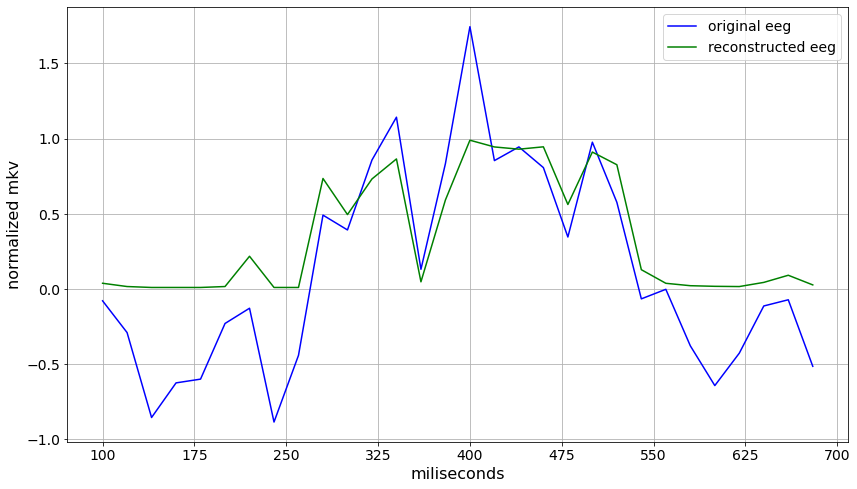

In [80]:
plot_orig_reconstr(original_x, reconstructed_x)

/home/alina/conda/anaconda3/envs/bdecode/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


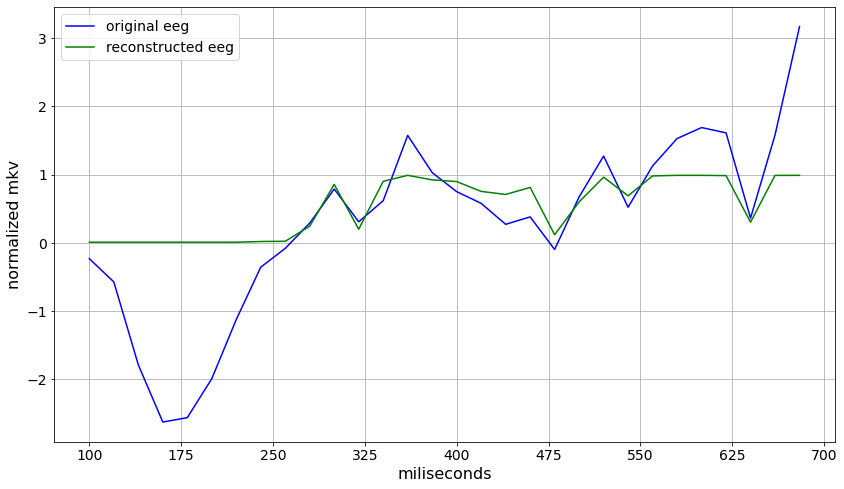

In [81]:
original_x = valid_set[1][0].view((8,30)).cpu().data.numpy()
reconstructed_x = model_x[1].view((8,30)).cpu().data.numpy()

plot_orig_reconstr(original_x, reconstructed_x)

### Augmentations

#### Target/non-target data

In [23]:
data = binary_transform_target(binds_train)
train_set = ListDataset(data)

In [24]:
data = binary_transform_target(binds_val)
valid_set = ListDataset(data)

In [25]:
alltargets_train = ListDataset(binary_transform(binds_train))
alltargets_val = ListDataset(binary_transform(binds_val))

In [165]:
benchmark = evaluate_game(ds_train, 5, clfs_full['LR'][0], bin_scores, log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('train mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('train roc_auc:', roc_auc.round(3))
print('train f1' , f1.round(3))

benchmark = evaluate_game(ds_val, 5, clfs_full['LR'][0], bin_scores,  log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('val mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('val roc_auc:', roc_auc.round(3))
print('val f1' , f1.round(3))

train mult_accuracy: 0.609 0.244 0.607
train roc_auc: 0.591
train f1 0.336
val mult_accuracy: 0.782 0.207 0.821
val roc_auc: 0.627
val f1 0.396


In [235]:
model = vae.VAE(64, epoch_shape[0]*epoch_shape[1], device='cpu')

In [236]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [237]:
trainer(model=model,
        optimizer=optimizer,
        dataset=train_set,
        count_of_epoch=100,
        batch_size=1024,
        progress=tqdm)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


##### Trained only on targets

In [166]:
benchmark = evaluate_game(ds_train, 5, clfs_full['LR'][0], bin_scores, augment_vae = model, log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('train mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('train roc_auc:',roc_auc.round(3))
print('train f1' , f1.round(3))

benchmark = evaluate_game(ds_val, 5, clfs_full['LR'][0], bin_scores,augment_vae = model,  log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('val mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('val roc_auc:', roc_auc.round(3))
print('val f1' , f1.round(3))

train mult_accuracy: 0.627 0.21 0.643
train roc_auc: 0.603
train f1 0.366
val mult_accuracy: 0.723 0.212 0.75
val roc_auc: 0.629
val f1 0.403


In [220]:
sample = model.generate_samples(100).mean(dim=0)

In [221]:
original_x = torch.stack([valid_set[i][0] for i in range(len(valid_set))]).mean(dim=0)
original_x = original_x.view((8,30)).cpu().data.numpy()
reconstructed_x = sample.view((8,30)).cpu().data.numpy()

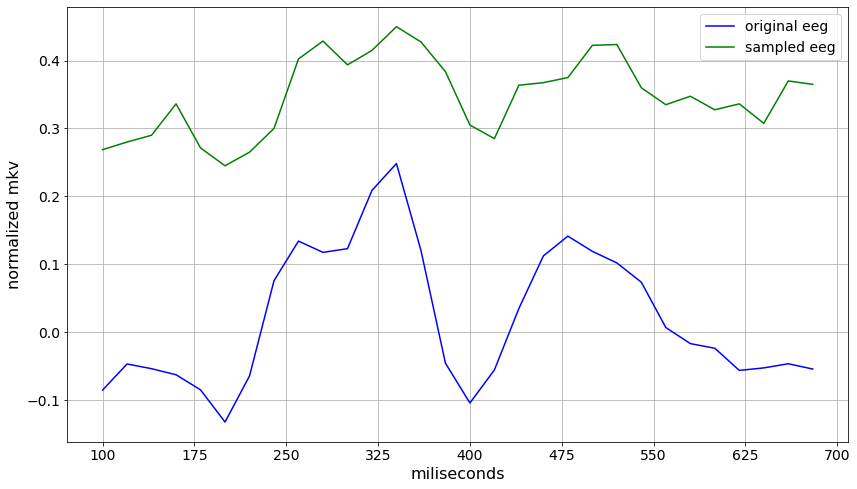

In [224]:
plot_orig_sampled(original_x, reconstructed_x)

##### Trained on all dataset

In [238]:
benchmark = evaluate_game(ds_train, 5, clfs_full['LR'][0], bin_scores, augment_vae = model, log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('train mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('train roc_auc:',roc_auc.round(3))
print('train f1' , f1.round(3))

benchmark = evaluate_game(ds_val, 5, clfs_full['LR'][0], bin_scores,augment_vae = model,  log=False)
acc_mean = np.mean(benchmark['mult']['accuracy'])
acc_std = np.std(benchmark['mult']['accuracy'])
acc_median = np.median(benchmark['mult']['accuracy'])
print('val mult_accuracy:',acc_mean.round(3), acc_std.round(3), acc_median.round(3))
roc_auc = np.mean(benchmark['bin']['roc_auc'])
f1 = np.mean(benchmark['bin']['f1'])
print('val roc_auc:', roc_auc.round(3))
print('val f1' , f1.round(3))

train mult_accuracy: 0.605 0.222 0.593
train roc_auc: 0.6
train f1 0.364
val mult_accuracy: 0.705 0.231 0.745
val roc_auc: 0.62
val f1 0.393


In [242]:
sample = model.generate_samples(100).mean(dim=0)

In [243]:
original_x = torch.stack([valid_set[i][0] for i in range(len(valid_set))]).mean(dim=0)
original_x = original_x.view((8,30)).cpu().data.numpy()
reconstructed_x = sample.view((8,30)).cpu().data.numpy()

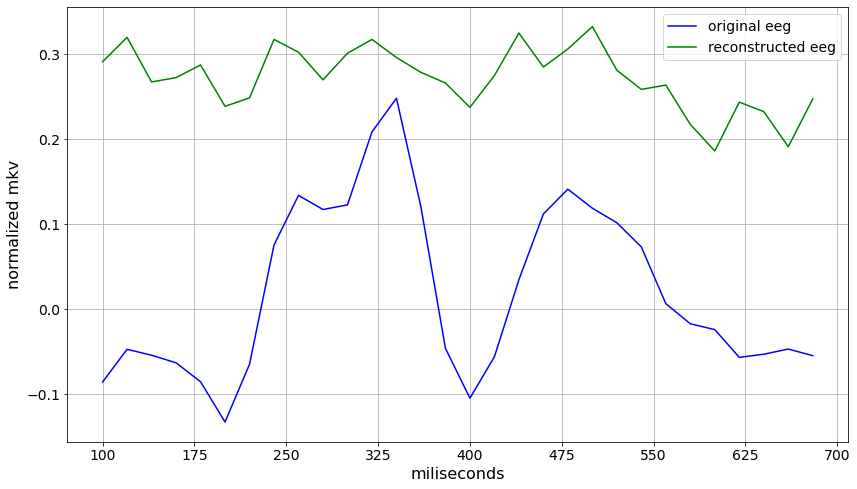

In [244]:
plot_orig_reconstr(original_x, reconstructed_x)